In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict, deque
import itertools as it
from utils import Labeler
import statsmodels
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
print(ndfs[1].groupby('cue').correct.mean())
print(ndfs[2].groupby('cue').correct.mean())

cue
honest     0.701222
neutral    0.687858
Name: correct, dtype: float64
cue
honest     0.700073
neutral    0.705519
Name: correct, dtype: float64


In [31]:
%%capture

ndfs = []
switches = []
final_qdfs = []
pdfs = []
exp23_misformat = 0
exp23_caught = 0
exp23_remain = 0

EXPERIMENT = 1
%run optimize_model.ipynb
ndfs.append(ndf)
final_qdfs.append(final_qdf)
switches.append(switch)
pdfs.append(pdf)

caught_pids = caught_pids
misformat_pids3 = misformat_pids

EXPERIMENT = 2
%run optimize_model.ipynb
ndfs.append(ndf)
final_qdfs.append(final_qdf)
switches.append(switch)
pdfs.append(pdf)
exp23_misformat += len(misformat_pids)
exp23_caught += len(caught_pids)
exp23_remain += len(pdf)

EXPERIMENT = 3
%run optimize_model.ipynb
ndfs.append(ndf)
final_qdfs.append(final_qdf)
switches.append(switch)
pdfs.append(pdf)
exp23_misformat += len(misformat_pids)
exp23_caught += len(caught_pids)
exp23_remain += len(pdf)

In [32]:
CODE_VERSION = 'all'
exp = 'ALL'

In [33]:
def cat2str(df):
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [34]:
for dfs in (ndfs, switches, final_qdfs, pdfs):
    for i, df in enumerate(dfs):
        df['experiment'] = "Exp {}".format(i+1)

ndf = pd.concat(map(cat2str, ndfs))
switch = pd.concat(map(cat2str, switches))
qdf = pd.concat(map(cat2str, final_qdfs))
pdf = pd.concat(map(cat2str, pdfs))

# Accuracy on normal trials

## Stats

In [35]:
df = ndf.groupby(["experiment", "cue", "feedback", "pidx"])["correct"].mean().unstack("cue")
# df

/usr/local/lib/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'pidx' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [36]:
df = ndf.groupby(["experiment", "cue", "feedback", "pidx"])["correct"].mean().unstack("cue")
df = df["honest"] - df["neutral"]
df = df.to_frame("diff").reset_index()

/usr/local/lib/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'pidx' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


In [37]:
%%R -i df -o aov

df$experiment <- as.factor(df$experiment)
df$feedback <- as.factor(df$feedback)
mod <- lm(diff ~ experiment * feedback, data=df)
aov <- Anova(mod, type='III')
aov 

Anova Table (Type III tests)

Response: diff
                     Sum Sq  Df F value    Pr(>F)    
(Intercept)         0.19284   1 22.3875 3.461e-06 ***
experiment          0.15447   2  8.9665 0.0001658 ***
feedback            0.22661   1 26.3079 5.282e-07 ***
experiment:feedback 0.10318   2  5.9893 0.0028204 ** 
Residuals           2.54108 295                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [38]:
aov_tbl = get_rtable(aov, p_col='prf')
tex_chi2 = r"$\chi^2({df:.0f})={sum_sq:.3f},\ {signif}$"
name = 'ANOVA_{idx}'
save_analysis(aov_tbl, name, tex_chi2, display_tex=True)

EXP3_ANOVA__INTERCEPT = $\chi^2(1)=0.193,\ p < 0.001$


<IPython.core.display.Latex object>

EXP3_ANOVA_EXPERIMENT = $\chi^2(2)=0.154,\ p < 0.001$


<IPython.core.display.Latex object>

EXP3_ANOVA_FEEDBACK = $\chi^2(1)=0.227,\ p < 0.001$


<IPython.core.display.Latex object>

EXP3_ANOVA_EXPERIMENT_FEEDBACK = $\chi^2(2)=0.103,\ p < 0.01$


<IPython.core.display.Latex object>

EXP3_ANOVA__RESIDUALS = $\chi^2(295)=2.541,\ nan$


<IPython.core.display.Latex object>

In [39]:
%%R -o comps

comps <- summary(lsmeans(mod, ~ experiment | feedback), infer = c(FALSE,TRUE), adjust="tukey", side=">")
comps

feedback = FALSE:
 experiment       lsmean         SE  df t.ratio p.value
 Exp 1       0.060897436 0.01287054 295   4.732  <.0001
 Exp 2       0.005015432 0.01339608 295   0.374  0.7307
 Exp 3      -0.012928022 0.01274854 295  -1.014  0.9962

feedback = TRUE:
 experiment       lsmean         SE  df t.ratio p.value
 Exp 1       0.155185185 0.01312542 295  11.823  <.0001
 Exp 2       0.021541950 0.01325868 295   1.625  0.1498
 Exp 3       0.002645503 0.01325868 295   0.200  0.8059

P value adjustment: sidak method for 3 tests 
P values are right-tailed 


In [40]:
# r = ri2py(results).rename(columns=to_snake_case)
comps_tbl = get_rtable(comps, 'p_value')
comps_tbl["experiment"] = comps_tbl["experiment"].replace({"Exp 1": "EXP1", "Exp 2": "EXP2", "Exp 3": "EXP3"})
comps_tbl

,experiment,feedback,lsmean,se,df,t_ratio,p_value,signif
1,EXP1,FALSE,0.060897,0.012871,295.0,4.731538,0.000005,p < 0.001
2,EXP2,FALSE,0.005015,0.013396,295.0,0.374395,0.730651,p = 0.73
3,EXP3,FALSE,-0.012928,0.012749,295.0,-1.014079,0.996226,p = 1.00
4,EXP1,TRUE,0.155185,0.013125,295.0,11.823251,0.000000,p < 0.001
5,EXP2,TRUE,0.021542,0.013259,295.0,1.624743,0.149760,p = 0.15
6,EXP3,TRUE,0.002646,0.013259,295.0,0.199530,0.805888,p = 0.81


In [41]:
tex_ttest = r"$\mu = {lsmean:.2f} \pm {se:.2f},\ t({df:.0f})={t_ratio:.2f},\ {signif}$"
save_analysis(comps_tbl, "COMP_{experiment}_{feedback}", tex_ttest, display_tex=False)

EXP3_COMP_EXP1_FALSE = $\mu = 0.06 \pm 0.01,\ t(295)=4.73,\ p < 0.001$
EXP3_COMP_EXP2_FALSE = $\mu = 0.01 \pm 0.01,\ t(295)=0.37,\ p = 0.73$
EXP3_COMP_EXP3_FALSE = $\mu = -0.01 \pm 0.01,\ t(295)=-1.01,\ p = 1.00$
EXP3_COMP_EXP1_TRUE = $\mu = 0.16 \pm 0.01,\ t(295)=11.82,\ p < 0.001$
EXP3_COMP_EXP2_TRUE = $\mu = 0.02 \pm 0.01,\ t(295)=1.62,\ p = 0.15$
EXP3_COMP_EXP3_TRUE = $\mu = 0.00 \pm 0.01,\ t(295)=0.20,\ p = 0.81$


## Plot

In [42]:
def signif_stars(g, comps_tbl):
    def star(ax, x, p):
        n_star = 3 if p < .001 else 2 if p < .01 else 1 if p < .05 else 0
        if n_star:
            g.axes.flat[ax].text(x, .225, '*' * n_star, fontsize=20, horizontalalignment='center')
    
    w = g.axes.flat[0].get_children()[0].get_width()
    for i, row in comps_tbl.iterrows():
        i -= 1
        if '<' in row.signif:
            x = (i // 3) - w + w * (i % 3)
            star(0, x, row.p_value)

In [43]:
WIDTH, HEIGHT = 4, 3

../paper/figs/3/experiment_differences.pdf


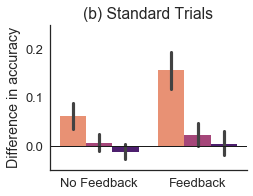

In [44]:
@plot()
def plot_experiment_differences(df=df):
    g = sns.factorplot(
        "feedback", "diff", hue="experiment", data=df,
        kind='bar', legend=False, palette="magma_r")

    ax = g.axes.flat[0]
    ax.set_ylim(-0.05, 0.25)
    ax.set_ylabel("Difference in accuracy")
    ax.set_xlabel("")
    ax.set_xticklabels(["No Feedback", "Feedback"])
    ax.axhline(0, color='k', ls='-', lw=1)
    ax.set_title('(b) Standard Trials')#, fontsize=18)

    plt.gcf().set_size_inches(WIDTH, HEIGHT)
    plt.tight_layout()

# Model


In [45]:
switch['switched'] = switch.pr_chisq < .001
switch['feedback'] = switch['feedback_cond']

../paper/figs/3/experiment_models.pdf


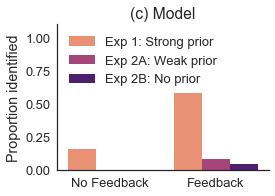

In [46]:
@plot()
def plot_experiment_models():
    g = sns.factorplot('feedback', 'switched', hue='experiment',
                       data=switch, kind='bar', ci=None, 
                       palette='magma_r', legend=False)
    ax = g.axes.flat[0]
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Proportion identified")
    ax.set_xlabel("")
    ax.set_xticklabels(["No Feedback", "Feedback"])
    ax.legend(["Exp 1: Strong prior", "Exp 2A: Weak prior", "Exp 2B: No prior"], loc="upper left")
    ax.axhline(0, color='k', ls='-', lw=1)
    ax.set_title('(c) Model')#, fontsize=18)

    plt.gcf().set_size_inches(WIDTH, HEIGHT)
    plt.tight_layout()

# Quiz

../paper/figs/3/experiments_quiz.pdf


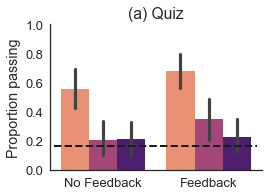

In [47]:
@plot()
def plot_experiments_quiz():
    g = sns.factorplot('feedback', 'perfect', hue='experiment', data=qdf,
                   kind='bar',palette='magma_r', legend=False)

    ax = g.axes.flat[0]
    ax.set_ylim(0, 1)
    ax.set_ylabel("Proportion passing")
    ax.set_xlabel("")
    ax.set_xticklabels(["No Feedback", "Feedback"])
    ax.axhline(0, color='k', ls='-', lw=1)
    ax.axhline(1/6, 0.02, 0.98, c='k',  ls='--', lw=2)
    ax.set_title('(a) Quiz')#, fontsize=18)

    plt.gcf().set_size_inches(WIDTH, HEIGHT)
    plt.tight_layout()